In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('C:\\Users\\Benja\\OneDrive\\Desktop\\Data Science Raw Data\\AirPassengers.csv')

In [2]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.rename(columns={'#Passengers': 'AirPassengers'}, inplace=True)

In [4]:
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

## Train Test Split

In [5]:
len(df)

144

In [6]:
144-12

132

In [7]:
train, test = df[:-12], df[-12:]

In [8]:
len(test)

12

In [9]:
test

,AirPassengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


## Scale Data

In [10]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [11]:
scaled_train

array([[0.01758242],
       [0.03076923],
       [0.06153846],
       [0.05494505],
       [0.03736264],
       [0.06813187],
       [0.0967033 ],
       [0.0967033 ],
       [0.07032967],
       [0.03296703],
       [0.        ],
       [0.03076923],
       [0.02417582],
       [0.04835165],
       [0.08131868],
       [0.06813187],
       [0.04615385],
       [0.0989011 ],
       [0.14505495],
       [0.14505495],
       [0.11868132],
       [0.06373626],
       [0.02197802],
       [0.07912088],
       [0.09010989],
       [0.1010989 ],
       [0.16263736],
       [0.12967033],
       [0.14945055],
       [0.16263736],
       [0.20879121],
       [0.20879121],
       [0.17582418],
       [0.12747253],
       [0.09230769],
       [0.13626374],
       [0.14725275],
       [0.16703297],
       [0.1956044 ],
       [0.16923077],
       [0.17362637],
       [0.25054945],
       [0.27692308],
       [0.3032967 ],
       [0.23076923],
       [0.19120879],
       [0.14945055],
       [0.197

In [12]:
len(scaled_train)

132

### Create the Model

In [13]:
# Let's redefine to get 12 months back and then predict the next month out
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [14]:
model = Sequential()
model.add(LSTM(200, activation='relu',return_sequences = True, input_shape=(n_input, n_features)))
model.add(LSTM(200, activation='relu',return_sequences = True, input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(LSTM(200, activation='relu',return_sequences = False, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics = ["accuracy"])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 12, 200)           320800    
                                                                 
 dropout (Dropout)           (None, 12, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit_generator(generator,epochs=90)

Epoch 1/90


120/120 [==============================] - 6s 19ms/step - loss: 0.0335 - accuracy: 0.0083
Epoch 2/90
120/120 [==============================] - 2s 19ms/step - loss: 0.0168 - accuracy: 0.0083
Epoch 3/90
120/120 [==============================] - 2s 19ms/step - loss: 0.0164 - accuracy: 0.0083
Epoch 4/90
120/120 [==============================] - 2s 18ms/step - loss: 0.0144 - accuracy: 0.0083
Epoch 5/90
120/120 [==============================] - 2s 20ms/step - loss: 0.0141 - accuracy: 0.0083
Epoch 6/90
120/120 [==============================] - 2s 14ms/step - loss: 0.0105 - accuracy: 0.0083
Epoch 7/90
120/120 [==============================] - 2s 18ms/step - loss: 0.0125 - accuracy: 0.0083
Epoch 8/90
120/120 [==============================] - 2s 19ms/step - loss: 0.0094 - accuracy: 0.0083
Epoch 9/90
120/120 [==============================] - 2s 20ms/step - loss: 0.0087 - accuracy: 0.0083
Epoch 10/90
120/120 [==============================] - 2s 18ms/step - loss: 0.0077 - accu

In [17]:
model.history.history.keys()

dict_keys(['loss', 'accuracy'])

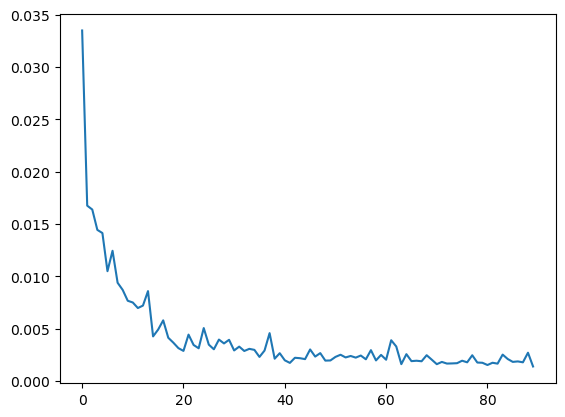

In [18]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [19]:
pred_list = []

batch = scaled_train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

1/1 [==============================] - 0s 28ms/step


In [20]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict], axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


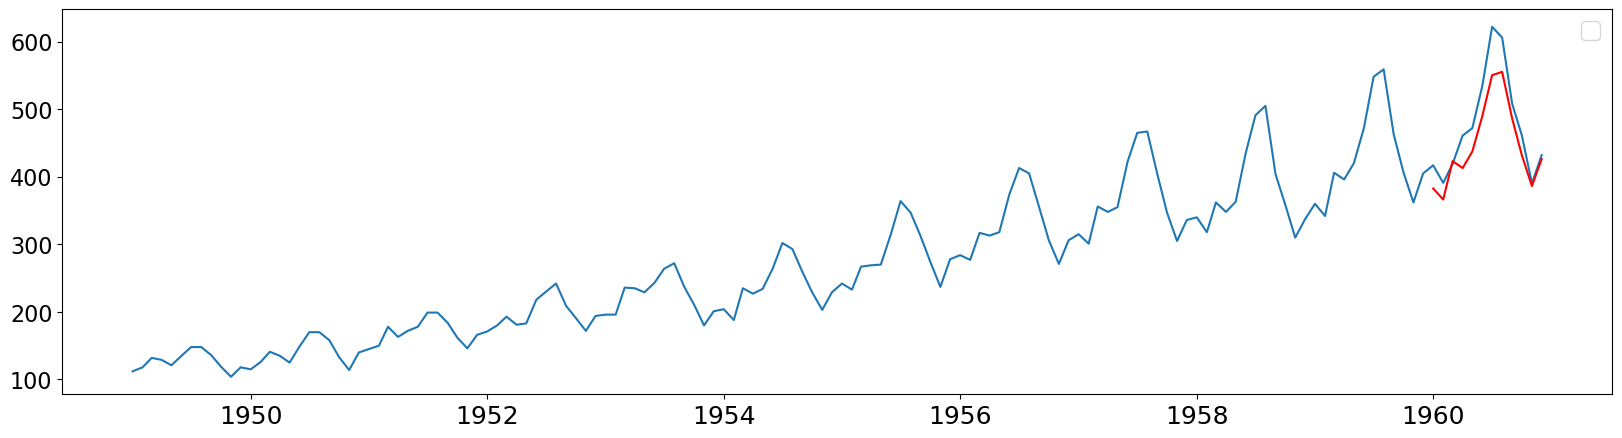

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['AirPassengers'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [22]:
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

rmse:  [36.97848792]


In [23]:
train = df

In [24]:
scaler.fit(train)
train = scaler.transform(train)

In [25]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [26]:
model.fit_generator(generator,epochs=90)

Epoch 1/90
22/22 [==============================] - 0s 18ms/step - loss: 0.0021 - accuracy: 0.0076
Epoch 2/90
22/22 [==============================] - 0s 20ms/step - loss: 0.0015 - accuracy: 0.0076
Epoch 3/90
22/22 [==============================] - 0s 21ms/step - loss: 0.0012 - accuracy: 0.0076
Epoch 4/90
22/22 [==============================] - 0s 18ms/step - loss: 0.0012 - accuracy: 0.0076 
Epoch 5/90
22/22 [==============================] - 0s 18ms/step - loss: 0.0011 - accuracy: 0.0076
Epoch 6/90
22/22 [==============================] - 0s 18ms/step - loss: 0.0013 - accuracy: 0.0076
Epoch 7/90
22/22 [==============================] - 0s 20ms/step - loss: 0.0011 - accuracy: 0.0076
Epoch 8/90
22/22 [==============================] - 0s 19ms/step - loss: 0.0011 - accuracy: 0.0076
Epoch 9/90
22/22 [==============================] - 0s 20ms/step - loss: 0.0014 - accuracy: 0.0076
Epoch 10/90
22/22 [==============================] - 1s 25ms/step - loss: 0.0012 - accuracy: 0.0076
Epoch 11

In [27]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
 # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])    
    pred_list.append(model.predict(batch)[0]) 
# update batch to now include prediction and drop first value    
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

1/1 [==============================] - 0s 33ms/step


In [28]:
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [29]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

In [30]:
pred_list

[array([0.6713165], dtype=float32),
 array([0.625904], dtype=float32),
 array([0.6762163], dtype=float32),
 array([0.75483143], dtype=float32),
 array([0.80548894], dtype=float32),
 array([0.98114735], dtype=float32),
 array([1.1249995], dtype=float32),
 array([1.0656964], dtype=float32),
 array([0.861195], dtype=float32),
 array([0.7602193], dtype=float32),
 array([0.6262777], dtype=float32),
 array([0.7027864], dtype=float32)]

In [31]:
scaled_test

array([[0.68791209],
       [0.63076923],
       [0.69230769],
       [0.78461538],
       [0.80879121],
       [0.94725275],
       [1.13846154],
       [1.1032967 ],
       [0.88791209],
       [0.78461538],
       [0.62857143],
       [0.72087912]])

## Inverse Transformations and Compare

In [32]:
true_predictions = scaler.inverse_transform(pred_list)

In [33]:
true_predictions

array([[451.74194932],
       [428.21828425],
       [454.28004563],
       [495.00268245],
       [521.24327302],
       [612.23432672],
       [686.749753  ],
       [656.0307138 ],
       [550.09902442],
       [497.79358494],
       [428.41184092],
       [468.04334795]])

In [34]:
test

,AirPassengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


In [35]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

In [36]:
test

,AirPassengers,Predictions
Month,,
1960-01-01,417,451.741949
1960-02-01,391,428.218284
1960-03-01,419,454.280046
1960-04-01,461,495.002682
1960-05-01,472,521.243273
1960-06-01,535,612.234327
1960-07-01,622,686.749753
1960-08-01,606,656.030714
1960-09-01,508,550.099024


<Axes: xlabel='Month'>

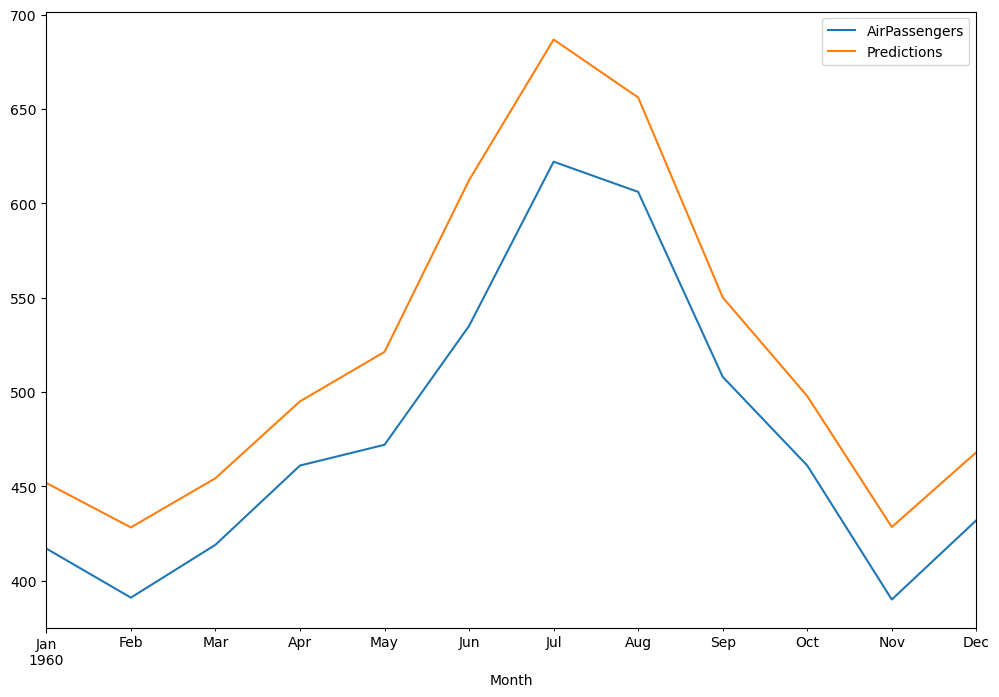

In [37]:
test.plot(figsize=(12,8))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


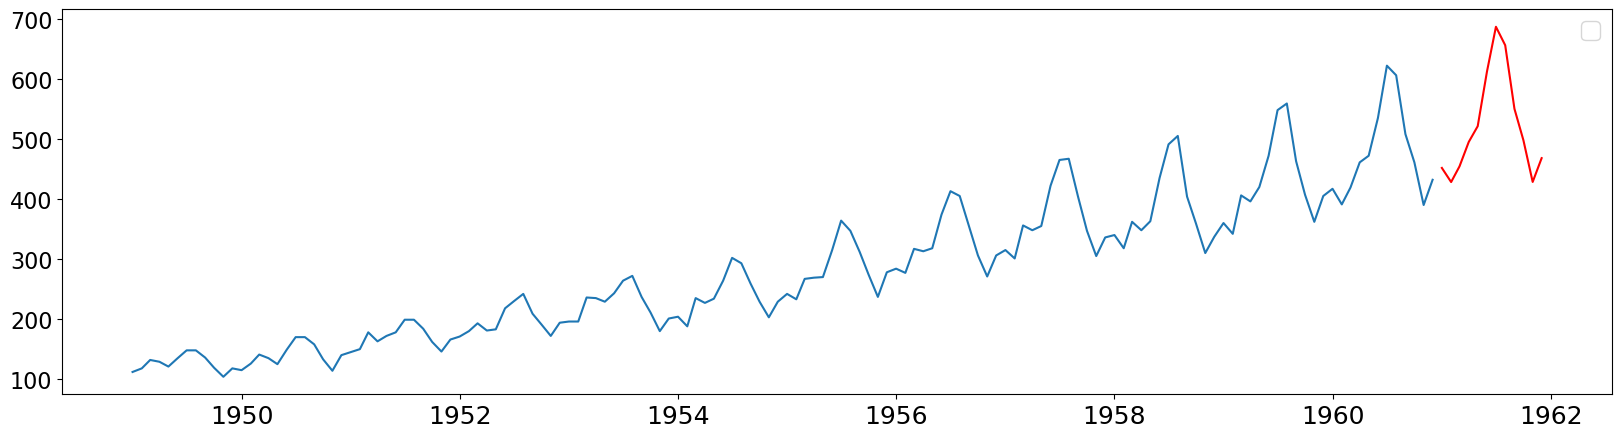

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['AirPassengers'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [39]:
## Save Predicted Results

In [40]:
#df_proj.to_csv('C:\\Users\\Benja\\OneDrive\\Desktop\\Data Science Raw Data\\12-Month Forecast With LSTM.csv', index = None, header=True)